# Text Cleaning

In this notebook we apply some text cleaning and feature engineering based on the books and save the resulting datasets.

In [1]:
import json
import os
import random
import numpy as np
import pandas as pd

random.seed(42)
np.random.seed(42)

### Loading Data

In [2]:
OUTPUT_DATA_DIR = "../output_data/"

train_df = pd.read_csv(OUTPUT_DATA_DIR+"interactions_training.csv")

val_df = pd.read_csv(OUTPUT_DATA_DIR+"interactions_validation.csv")

test_df = pd.read_csv(OUTPUT_DATA_DIR+"interactions_testing.csv")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def process_book_text(book_text, exclude_text, ps):
    """Pre-processes the text given by `review_text`.

    Parameters
    ----------
    book_text: str
        The book text to be processed.
    exclude_text: collection
        A collection of words to be excluded.
    ps: PorterStemmer
        The PorterStemmer used to perform word stemming.

    Returns
    -------
    str
        A string representing the processed version of `review_text`.

    """
    book = re.sub('[^a-zA-Z0-9]', ' ', book_text).lower().split()
    book = [ps.stem(word) for word in book if not word in exclude_text]
    return ' '.join(book)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Matthew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def median_impute(data_df, col_lst):
    """For each column in `col_lst`, missing values are imputed with the median.

    Parameters
    ----------
    data_df: pd.DataFrame
        The DataFrame on which the imputation is done.
    col_lst: collection
        The collection of columns being imputed.

    Returns
    -------
    pd.DataFrame
        The DataFrame obtained from `data_df` after performing the imputation.

    """
    for col in col_lst:
        median_val = data_df[col].median()
        data_df[col] = data_df[col].apply(lambda x: median_val if pd.isnull(x) else x)
    return data_df

In [5]:
def preprocess_for_classification(data_df):
    """Preprocesses `data_df` to be used in classification.

    Parameters
    ----------
    data_df: pd.DataFrame
        The DataFrame to be processed.

    Returns
    -------
    pd.DataFrame
        The DataFrame obtained from `data_df` after processing.

    """
    # flags for most popular formats
    data_df['format'] = data_df['format'].apply(lambda x: str(x).lower())
    data_df['is_paperback'] = data_df['format'].apply(lambda x: int("paper" in x))
    data_df['is_hardcover'] = data_df['format'].apply(lambda x: int("hard" in x))
    data_df['is_audio'] = data_df['format'].apply(lambda x: int("audio" in x))
    data_df['is_ebook'] = data_df['is_ebook'].apply(lambda x: int(x))
    data_df['is_other_format'] = (data_df['is_paperback'] + data_df['is_hardcover'] +
                                  data_df['is_audio'] + data_df['is_ebook'])
    data_df['is_other_format'] = data_df['is_other_format'].apply(lambda x: 0 if x > 0 else 1)

    #flags for most popular publishers
    data_df['publisher'] = data_df['publisher'].apply(lambda x: str(x).lower())
    data_df['from_penguin'] = data_df['publisher'].apply(lambda x: int("penguin" in x))
    data_df['from_harpercollins'] = data_df['publisher'].apply(lambda x: int("harpercollins" in x or "harper collins" in x))
    data_df['from_university_press'] = data_df['publisher'].apply(lambda x: int("university press" in x))
    data_df['from_vintage'] = data_df['publisher'].apply(lambda x: int("vintage" in x))
    data_df['from_createspace'] = data_df['publisher'].apply(lambda x: int("createspace" in x or "create space" in x))
    data_df['other_publisher'] = (data_df['from_penguin'] + data_df['from_harpercollins'] +
                                  data_df['from_university_press'] + data_df['from_vintage'] + data_df['from_createspace'])
    data_df['other_publisher'] = data_df['other_publisher'].apply(lambda x: 0 if x > 0 else 1)

    data_df = median_impute(data_df, ['num_pages', 'publication_year'])

    # flags for most popular authors
    data_df['main_author'] = data_df['main_author'].astype(str)
    data_df['author_a'] = data_df['main_author'].apply(lambda x: int(x == "435477.0"))
    data_df['author_b'] = data_df['main_author'].apply(lambda x: int(x == "903.0"))
    data_df['author_c'] = data_df['main_author'].apply(lambda x: int(x == "947.0"))
    data_df['author_d'] = data_df['main_author'].apply(lambda x: int(x == "4624490.0"))
    data_df['author_e'] = data_df['main_author'].apply(lambda x: int(x == "18540.0"))
    data_df['author_f'] = data_df['main_author'].apply(lambda x: int(x == "8075577.0"))
    data_df['author_other'] = (data_df['author_a'] + data_df['author_b'] +
                               data_df['author_c'] + data_df['author_d'] +
                               data_df['author_e'] + data_df['author_f'])
    data_df['author_other'] = data_df['author_other'].apply(lambda x: 0 if x > 0 else 1)
    return data_df

In [6]:
def get_total_shelved_count(shelves_str):
    """Find the total number of shelves that a book is in.

    Parameters
    ----------
    str: shelves_str
        a json encoded dictionary contrining the shelving information.

    Returns
    -------
    int
        total number of shelves a book is in.

    """

    total = 0
    shelves_str = shelves_str.replace("\'", "\"")
    shelves_list = json.loads(shelves_str)
    for shelve in shelves_list:
        total += int(shelve['count'])
    return total

In [7]:
def get_title_len(row):
    """Get the length of the title of the book.

    Parameters
    ----------
    DataFrame Row: row
        A row of DataFrame corresponding the the book

    Returns
    -------
    int
        The length of the title. Returns 0 on failure

    """

    try:
        return len(row['title'])
    except:
        return 0

In [8]:
def preprocess_all_book_text(data_df, id_col, text_col, exclude_text, ps):
    """Preprocesses the book text in `data_df` for `text_col`.

    The dataframe is restricted to `id_col` and `text_col` and then the
    unique ids are chosen. This is so that we only preprocess the text
    for a book once. Then we join the resulting text back to `data_df`.

    Parameters
    ----------
    data_df: pd.DataFrame
        The DataFrame containing the data to be preprocessed.
    id_col: str
        The column from which unique ids are chosen.
    text_col: str
        The column to be pre-processed.
    exclude_text: collection
        A collection of words to remove
    ps: PorterStemmer
        The PorterStemmer used for word stemming.

    Returns
    -------
    pd.DataFrame
        The DataFrame obtained from `data_df` after adding a column
        with the processed text.

    """
    book_df = data_df[[id_col, text_col]]
    book_df = book_df.drop_duplicates(subset=[id_col])
    book_df['cleaned_text'] = book_df[text_col].apply(lambda x: process_book_text(x, exclude_text, ps))
    final_df = pd.merge(data_df, book_df[[id_col, "cleaned_text"]], how="inner", on=[id_col])
    return final_df

In [9]:
def run_preprocess_pipeline(data_df, exclude_text, ps):
    """Runs the full pre-processing pipeline on `data_df`.

    Parameters
    ----------
    data_df: pd.DataFrame

    """
    processed_df = preprocess_for_classification(data_df)
    
    processed_df['book_shelved_count'] = processed_df.apply(lambda row: get_total_shelved_count(row['popular_shelves']), axis=1)
    processed_df['title_len'] = processed_df.apply(lambda row: get_title_len(row), axis=1)
    
    fillna_columns = ['text_reviews_count','average_rating', 'ratings_count']
    processed_df[fillna_columns] = processed_df[fillna_columns].fillna(0)
    
    return preprocess_all_book_text(processed_df, "book_id", "title_description", exclude_text, ps)

In [10]:
exclude_english = set(stopwords.words('english'))
ps = PorterStemmer()
train_df_processed = run_preprocess_pipeline(train_df, exclude_english, ps)
val_df_processed = run_preprocess_pipeline(val_df, exclude_english, ps)
test_df_processed = run_preprocess_pipeline(test_df, exclude_english, ps)

In [11]:
book_texts = train_df_processed[['book_id', 'cleaned_text']]
book_texts = book_texts.drop_duplicates(subset=['book_id'])

full_text = " ".join(list(book_texts['cleaned_text'])) + " "

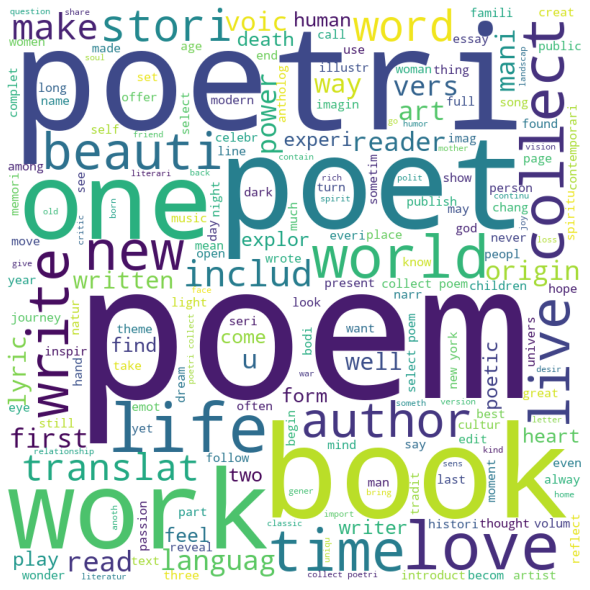

In [12]:
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.style.use('seaborn-darkgrid')
%matplotlib inline
sns.set(font_scale=1.5)

word_cloud = WordCloud(width=800, height=800,
                       background_color='white',
                       min_font_size=10).generate(full_text)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [13]:
print(len(train_df_processed) + len(val_df_processed) + len(test_df_processed))

326905


In [14]:
import json

interactions_file = os.path.join("../data", "goodreads_interactions_poetry.json")

users = []
with open(interactions_file, 'r') as data_file:
    for row in data_file:
        users.append(json.loads(row)['user_id'])

np_users = np.array(users)
del users

In [15]:
print(len(np.unique(np_users)))

377799


In [16]:
def plot_shelved_vs_recommended(data_df, col_lst, plot_name):
    shelved = []
    recommended = []
    for col in col_lst:
        shelved.append(data_df[data_df[col] == 1]['shelved'].sum())
        recommended.append(data_df[data_df[col] == 1]['recommended'].sum())
    
    plot_df = pd.DataFrame({plot_name: col_lst,
                            'shelved': shelved,
                            'recommended': recommended})
    
    fig, ax = plt.subplots(figsize=(20, 10))
    stacked_df = plot_df.melt(id_vars=plot_name).rename(columns=str.title)
    sns.barplot(x=plot_name, y='Value', hue='Variable', data=stacked_df, ax=ax)
    sns.despine(fig)

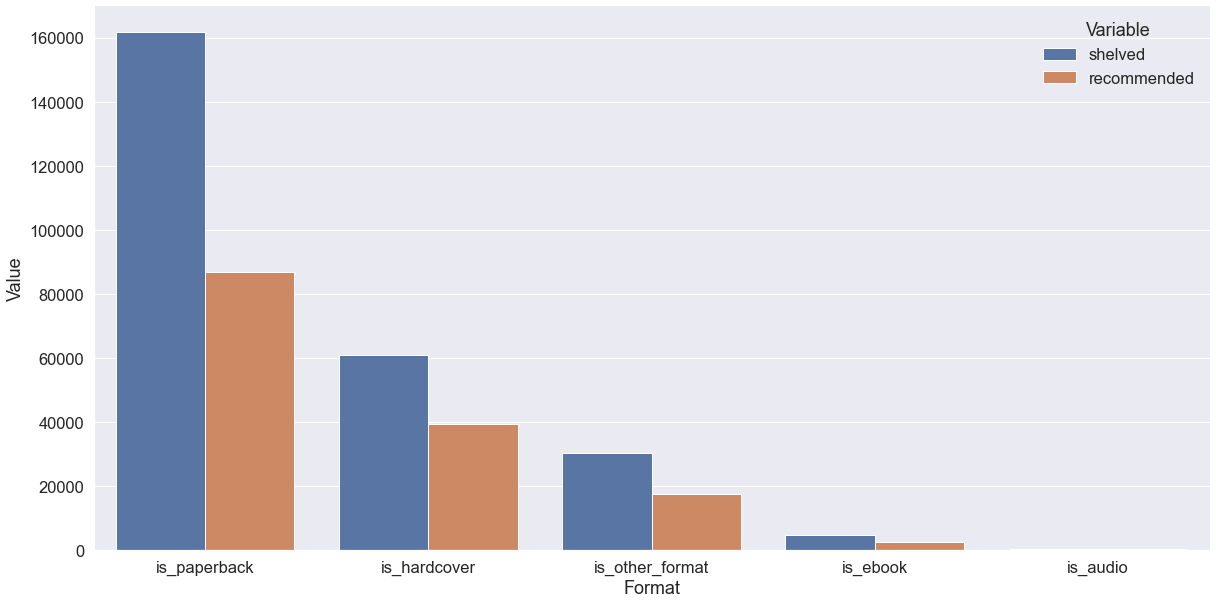

In [17]:
plot_shelved_vs_recommended(
    train_df_processed, 
    ['is_paperback', 'is_hardcover', 'is_other_format', 'is_ebook', 'is_audio'],
    "Format")

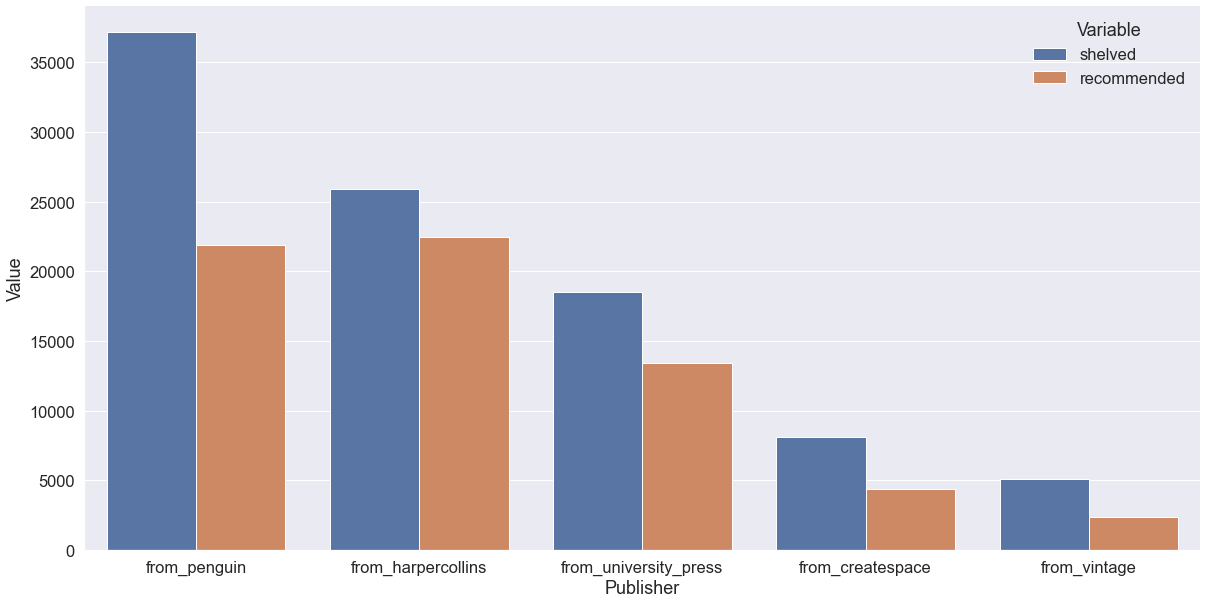

In [18]:
plot_shelved_vs_recommended(
    train_df_processed, 
    ['from_penguin', 'from_harpercollins', 'from_university_press', 'from_createspace', 'from_vintage'],
    "Publisher")

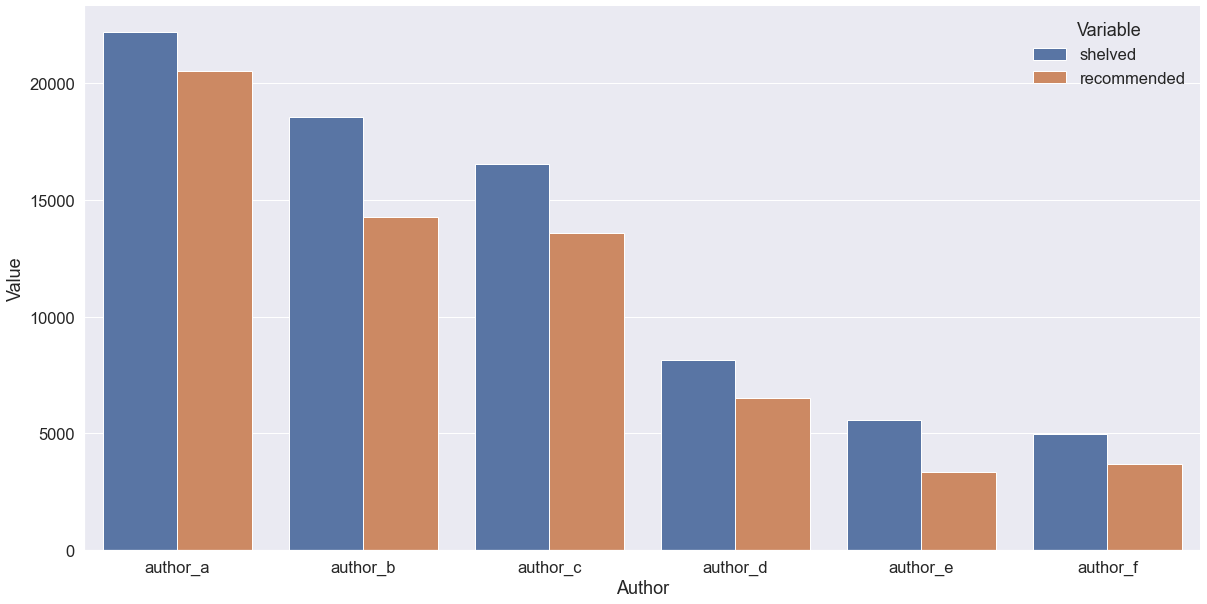

In [19]:
plot_shelved_vs_recommended(
    train_df_processed, 
    ['author_a', 'author_b', 'author_c', 'author_d', 'author_e', 'author_f'],
    "Author")

In [20]:
from sklearn.utils import shuffle

def shuffle_dataset(data_df):
    """Randomly shuffles `df`.

    Parameters
    ----------
    df: pd.DataFrame
        The DataFrame to be shuffled.

    Returns
    -------
    pd.DataFrame
        A shuffled dataframe obtained from `df`.

    """
    data_df = shuffle(data_df)
    data_df.reset_index(inplace=True, drop=True)
    return data_df

In [21]:
train_df_processed = shuffle_dataset(train_df_processed)
val_df_processed = shuffle_dataset(val_df_processed)
test_df_processed = shuffle_dataset(test_df_processed)

In [22]:
train_df_processed.to_csv(OUTPUT_DATA_DIR+"text_processed_training.csv", index=False)
val_df_processed.to_csv(OUTPUT_DATA_DIR+"text_processed_validation.csv", index=False)
test_df_processed.to_csv(OUTPUT_DATA_DIR+"text_processed_testing.csv", index=False)